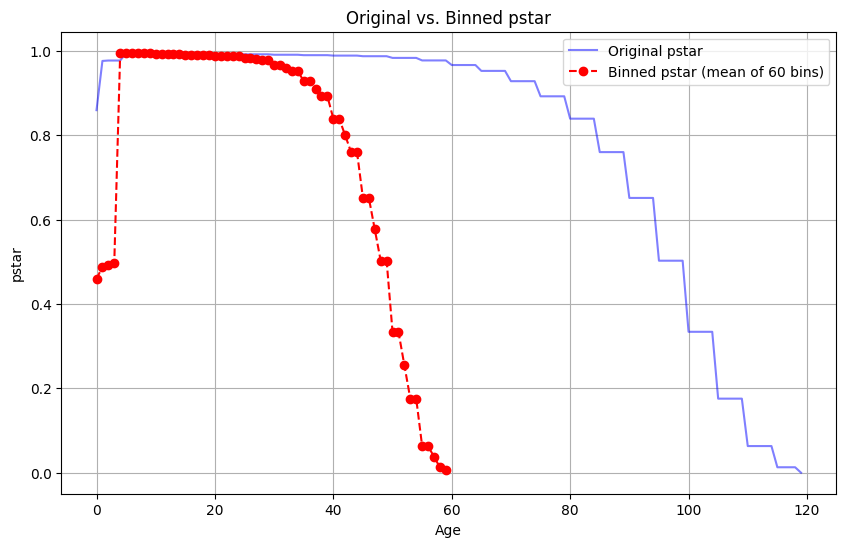

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

vec1 = pd.read_csv('demog_vectors.csv')
vec1 = vec1.rename_axis('age').reset_index()
new_max_age = 60
old_max_age = vec1['age'].max()
scale_factor = new_max_age / old_max_age
scale_factor = 1
other_para = ['rho', 'pstar', 'mortparms']

bins = pd.cut(vec1['age'], bins=new_max_age)

binned_vec = pd.DataFrame()

for col in other_para:
    binned_col = vec1.groupby(bins, observed=False).agg({col: 'mean'}).reset_index()
    binned_col[col] = binned_col[col] * scale_factor
    binned_vec[col] = binned_col[col]

binned_vec = binned_vec.rename_axis('age_new').reset_index()
# lower survival probability for infants (0-3 years)
binned_vec.loc[binned_vec['age_new'] <= 3, 'pstar'] *= 0.5
    
bin_centers = [interval.mid for interval in binned_col['age']]
plt.figure(figsize=(10, 6))
plt.plot(vec1['age'], vec1['pstar'], label='Original pstar', color='blue', alpha=0.5)

plt.plot(binned_vec['age_new'], binned_vec['pstar'], label='Binned pstar (mean of 60 bins)', color='red', linestyle='--', marker='o')

plt.title('Original vs. Binned pstar')
plt.xlabel('Age')
plt.ylabel('pstar')
plt.legend()
plt.grid(True)
plt.show()


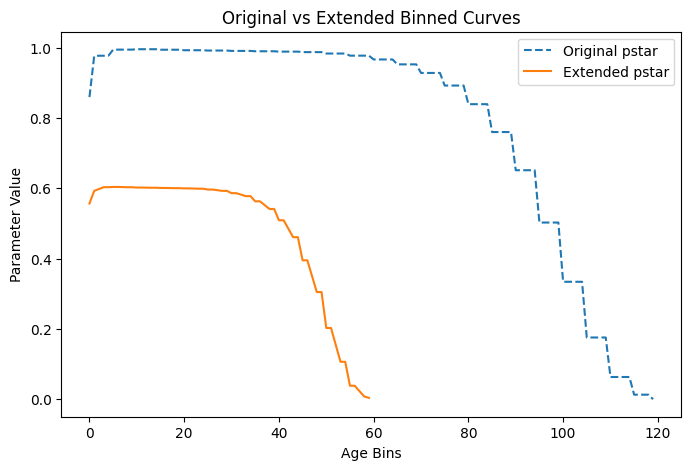

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

vec1 = pd.read_csv('demog_vectors.csv')
vec1 = vec1.rename_axis('age').reset_index()

new_max_age = 60

other_para = ['rho', 'pstar', 'mortparms']

bins = pd.cut(vec1['age'], bins=new_max_age)
binned_vec = pd.DataFrame()

for col in other_para:
    binned_col = vec1.groupby(bins, observed=False).agg({col: 'mean'}).reset_index()
    binned_vec[col] = binned_col[col]


def extend_tail(values, start_idx, decay_rate=0.5):
    for i in range(start_idx, len(values)):
        values[i] = values[i] * np.exp(-decay_rate)
        # values[i] = values[i] * 1
    return values

start_idx = int(0.02 * len(binned_vec))  
start_idx = 0

for col in ['pstar']:
    binned_vec[col] = extend_tail(binned_vec[col].values, start_idx)


bin_centers = [interval.mid for interval in binned_col['age']]
binned_vec = binned_vec.rename_axis('age_new').reset_index()

plt.figure(figsize=(8, 5))
for col in ['pstar']:
    plt.plot(vec1.index, vec1[col], label=f'Original {col}', linestyle='dashed')
    plt.plot(binned_vec.index, binned_vec[col], label=f'Extended {col}')

plt.xlabel('Age Bins')
plt.ylabel('Parameter Value')
plt.title('Original vs Extended Binned Curves')
plt.legend()
plt.show()

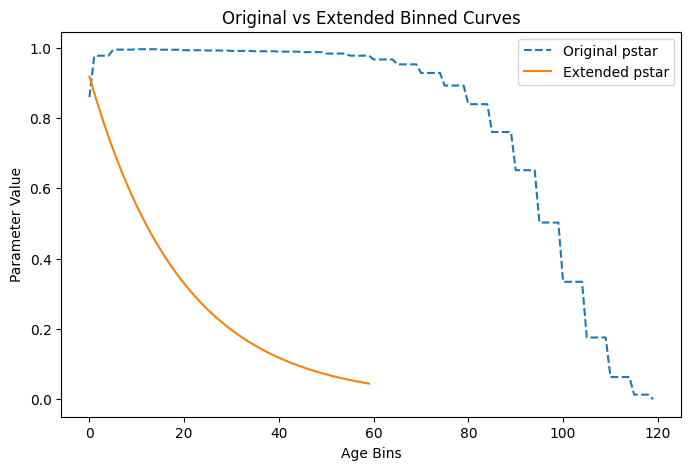

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

vec1 = pd.read_csv('demog_vectors.csv')
vec1 = vec1.rename_axis('age').reset_index()

new_max_age = 60
other_para = ['rho', 'pstar', 'mortparms']

bins = pd.cut(vec1['age'], bins=new_max_age)
binned_vec = pd.DataFrame()

for col in other_para:
    binned_col = vec1.groupby(bins, observed=False).agg({col: 'mean'}).reset_index()
    binned_vec[col] = binned_col[col]

def smooth_tail(values, start_idx, decay_factor=0.95):
    for i in range(start_idx, len(values)):
        values[i] = values[i - 1] * decay_factor if i > 0 else values[i]
    return values

start_idx = int(0.02 * len(binned_vec))  
start_idx = 0

for col in ['pstar']:
    binned_vec[col] = smooth_tail(binned_vec[col].values, start_idx)

bin_centers = [interval.mid for interval in binned_col['age']]
binned_vec = binned_vec.rename_axis('age_new').reset_index()

plt.figure(figsize=(8, 5))
for col in ['pstar']:
    plt.plot(vec1.index, vec1[col], label=f'Original {col}', linestyle='dashed')
    plt.plot(binned_vec.index, binned_vec[col], label=f'Extended {col}')

plt.xlabel('Age Bins')
plt.ylabel('Parameter Value')
plt.title('Original vs Extended Binned Curves')
plt.legend()
plt.show()


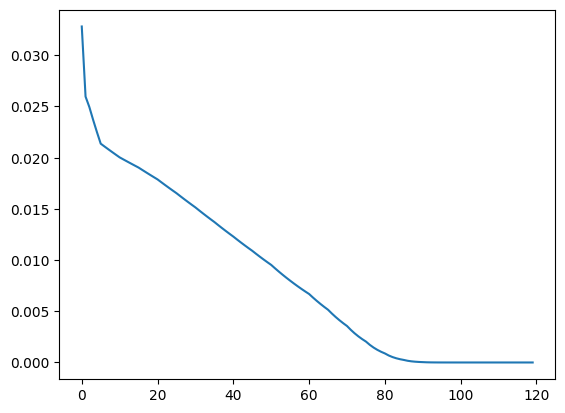

In [3]:
import numpy as np
import scipy.linalg as sl
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp

# 1. load the demographic parameters
vec1 = pd.read_csv('demog_vectors.csv')

# 2. generate a Leslie-matrix for the equilibrium case (z = 0.667, could
def get_matrix(z, vec1):
     p0 = vec1.pstar * sp.gdtr(1.0/vec1.mortscale[0], vec1.mortparms, z)
     m0 = vec1.mstar * sp.gdtr(1.0/vec1.fertscale[0], vec1.fertparm[0], z)
     N = len(p0)
     m1 = np.zeros([N,N])
     for i in range(N-1):
         m1[i+1,i] = p0[i]
     m1[0,] = m0
     return m1

m1 = get_matrix(0.667, vec1)

# 3. calculate the eigenvalues and vectors and select the largest
eigvals, eigvecs = sl.eig(m1)
ix = eigvals.real.argmax()
if eigvals[ix].imag != 0.0:
     raise BaseException('Invalid solution!\n')
if np.any(eigvecs[:,ix].imag != 0.0):
     raise BaseException('Invalid solution!\n')
popdst = eigvecs[:,ix]
if popdst[0] < 0.0:
     popdst *= -1
if np.any(popdst < 0.0):
     raise BaseException('Invalid solution!\n')
popdst = popdst.real / sum(popdst.real)

# here, popdst is the age distribution in equilibrium
# you can use it directly to generate initial ages with np.multinomial

# 4. save the result to a csv
popdf = pd.DataFrame({'age': range(len(popdst)), 'p': popdst})
# popdf.to_csv('popdst.csv', index=False)

# 5. plot to distribution to confirm
plt.plot(popdst)




In [9]:
vec1 = pd.read_csv('demog_vectors_scaled.csv')
p0 = vec1.pstar.values  # survival probabilities
m0 = vec1.mstar.values  # fertility rates
N = len(p0)  # number of age groups
m1 = np.zeros((N, N))  # initialize N x N matrix
m1[0, :] = m0  # set fertility rates in the first row

for i in range(N - 1):
    m1[i + 1, i] = p0[i]  # set survival probabilities in sub-diagonal

eigvals, eigvecs = sl.eig(m1)  # sompute eigenvalues and eigenvectors
lambda_max = np.max(eigvals.real)
lambda_max

2.3809192637883094

In [4]:
m1

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.79113491, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.96060542, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01069607, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01069607,
        0.        ]])

### Calculate Eigenvalue

In [8]:
vec1 = pd.read_csv('demog_vectors_scaled.csv')

p0 = vec1["pstar"].values  # Survival probabilities
m0 = vec1["mstar"].values  # Fertility rates
N = len(p0)  # Number of age groups
m1 = np.zeros((N, N))  # Initialize N x N matrix
m1[0, :] = m0  # Set fertility rates in the first row

for i in range(N - 1):
    m1[i + 1, i] = p0[i]  # Set survival probabilities in sub-diagonal

eigvals, eigvecs = sl.eig(m1)  # Compute eigenvalues and eigenvectors
lambda_max = np.max(eigvals.real)  # Largest eigenvalue (real part)

lambda_max

0.4761838527576592

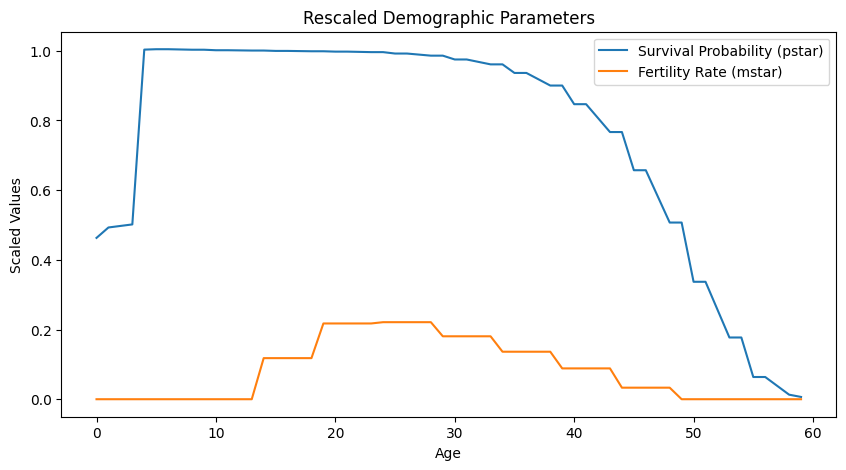

In [5]:
import matplotlib.pyplot as plt
vec1 = pd.read_csv('demog_vectors_scaled.csv')
plt.figure(figsize=(10, 5))
plt.plot(vec1['age_new'], vec1['pstar'], label='Survival Probability (pstar)')
plt.plot(vec1['age_new'], vec1['mstar'], label='Fertility Rate (mstar)')
plt.xlabel('Age')
plt.ylabel('Scaled Values')
plt.legend()
plt.title('Rescaled Demographic Parameters')
plt.show()

In [2]:
metrics = {
                "Population Over Time": [1, 2, 3],
                "Occupied Land Capacity":[1, 4, 5]
            }

In [6]:
for i in metrics.values():
    print(i)

[1, 2, 3]
[1, 4, 5]


In [3]:
list(range(500))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
